In [1]:
from torchtext.datasets import IMDB

train_iter = IMDB(split='train')
test_iter = IMDB(split='test')

In [2]:
import random
random.seed(6)

train_lists = list(train_iter)
test_lists = list(test_iter)

train_lists_small = random.sample(train_lists, 1000)
test_lists_small = random.sample(test_lists, 1000)

print(train_lists_small[0])
print(test_lists_small[0])

(2, "I LOVED this movie! I am biased seeing as I am a huge Disney fan, but I really enjoyed myself. The action takes off running in the beginning of the film and just keeps going! This is a bit of a departure for Disney, they don't spend quite as much time on character development (my husband pointed this out)and there are no musical numbers. It is strictly action adventure. I thoroughly enjoyed it and recommend it to anyone who loves Disney, be they young or old.")
(1, 'This was an abysmal show. In short it was about this kid called Doug who guilt-tripped a lot. Seriously he could feel guilty over killing a fly then feeling guilty over feeling guilty for killing the fly and so forth. The animation was grating and unpleasant and the jokes cheap. <br /><br />It aired here in Sweden as a part of the "Disney time" show and i remember liking it some what but then i turned 13.<br /><br />I never got why some of the characters were green and purple too. What was up with that? <br /><br />Tru

In [3]:
train_texts = []
train_labels = []

for label, text in train_lists_small:
    train_texts.append(text)
    train_labels.append(1 if label==2 else 0)

test_texts = []
test_labels = []

for label, text in test_lists_small:
    test_texts.append(text)
    test_labels.append(1 if label==2 else 0)



In [4]:
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.2, random_state=3)

In [5]:
from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(train_texts, truncation=True, padding=True) # truncation=True는 모델의 디폴트 max_length를 넘는 입력 부분은 더 이상 받지 않고 절단 padding은 max_length보다 토큰이 작으면 남는자리가 <PAD> 토큰으로 교체됨
valid_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

c:\Users\175091\AppData\Local\anaconda3\envs\llm\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import torch

class IMDbDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __getitem__(self, idx):
        # self.encoding에 담긴 키와 키값을 items()로 추출
        # 이 값을 key와 val 변수에 담아 새로운 키와 키값을 갖는 딕셔너리 생성
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        
        item['labels'] = torch.tensor(self.labels[idx])
        return item 
    
    def __len__(self):
        return len(self.labels)
    
    

In [7]:
train_dataset = IMDbDataset(train_encodings, train_labels)
val_dataset = IMDbDataset(valid_encodings, val_labels)
test_dataset = IMDbDataset(test_encodings, test_labels)

In [8]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def test_inference(model, tokenizer):
    input_tokens = tokenizer(["I feel fantastic", "My life is going something wrong", "I have not figured out what the chosen title has to do with the movie."], truncation=True, padding=True)
    
    outputs = model(torch.tensor(input_tokens['input_ids']).to(device))
    label_dict = {1:'positive', 0:'negative'}
    
    return [label_dict[i] for i in torch.argmax(outputs['logits'], axis=1).cpu().numpy()]

In [11]:
from torch.utils.data import DataLoader
from transformers import DistilBertForSequenceClassification, AdamW
from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
model.to(device)

print(test_inference(model, tokenizer))

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

optim = AdamW(model.parameters(), lr=5e-5)

model.train()

losses = []

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


['negative', 'negative', 'positive']


c:\Users\175091\AppData\Local\anaconda3\envs\llm\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [12]:
for epoch in range(8):
    print(f'epoch:{epoch}')
    for batch in train_loader:
        optim.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        
        loss = outputs[0]
        losses.append(loss)
        
        loss.backward()
        
        optim.step()

epoch:0
epoch:1
epoch:2
epoch:3
epoch:4
epoch:5
epoch:6
epoch:7


In [13]:
model.eval()
print(test_inference(model, tokenizer))

['positive', 'negative', 'negative']


In [14]:
print(losses)
type(losses)

[tensor(0.6990, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.7030, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.7086, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.7007, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.7098, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.6836, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.6692, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.6927, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.6857, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.6757, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.6602, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.6932, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.6444, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.6678, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.6499, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.6067, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.6755, device='

list

In [16]:
new_losses = [i.item() for i in losses]

new_losses[:5]

[0.6989691257476807,
 0.7029625177383423,
 0.7086413502693176,
 0.7007300853729248,
 0.7097991704940796]

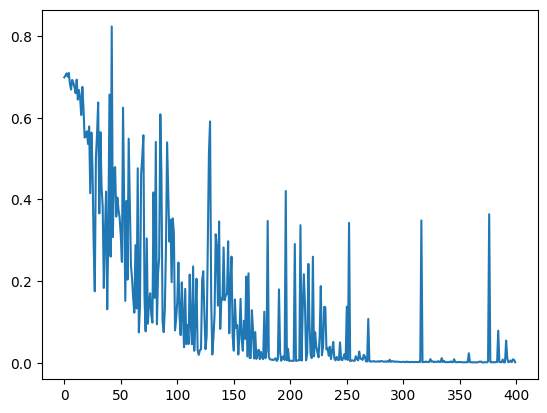

In [19]:
import matplotlib.pyplot as plt
plt.plot(new_losses)
plt.show();

In [20]:
model.eval()

l = []

for test_text in test_texts:
    
    input_tokens = tokenizer([test_text], truncation=True, padding=True)
    
    outputs = model(torch.tensor(input_tokens['input_ids']).to(device))
    
    l.append(torch.argmax(outputs['logits'], axis=1).item())

correct_cnt = 0

for pred, ans in zip(l, test_labels):
    if pred == ans: 
        correct_cnt += 1

print(correct_cnt/len(test_labels))

0.855


In [21]:
tp = 0
tn = 0
fp = 0
fn = 0

for pred, ans in zip(l, test_labels):
    if pred == ans:
        if pred == 1:
            tp += 1
        else:
            tn += 1
    
    elif pred == 0:
        fn += 1
    
    elif pred == 1:
        fp += 1

recall = tp / (tp+fn)
print(recall)

precision = tp / (tp+fp)
print(precision)

f1 = (2*precision*recall) / (precision + recall)
print(f1)

0.7682672233820459
0.9154228855721394
0.8354143019296255


In [22]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, l))

              precision    recall  f1-score   support

           0       0.81      0.93      0.87       521
           1       0.92      0.77      0.84       479

    accuracy                           0.85      1000
   macro avg       0.86      0.85      0.85      1000
weighted avg       0.86      0.85      0.85      1000

